# Uncovering the HML Factor

The notebook demonstrates the decomposition approach towards uncovering the Fama-French HML factor (1993) built from the difference between high and low portfolios sorted with the book-to-market metric. Following the incremental methodology, the example focuses on the top 50% of stocks based on market cap. Considering the low (growth) and high (value) assets as winners and losers, the approach transparently describes the Big HML factor as a sampling of stocks based on the GPOA (gross profit on assets) fundamental characteristic.

The notebook is structured as follows:
<ol>
    <li><a href='#section1'>Loading Sharadar Data</a></li>
    <li><a href='#section2'>Data Post-Processing</a></li>
    <li><a href='#section3'>Building the Big HML Value and Growth Portfolios</a></li>
    <li><a href='#section4'>Benchmarking Portfolios with French Data Library </a></li>
    <li><a href='#section5'>Loading and Post-Processing Sharadar Fundamentals </a></li>
    <li><a href='#section6'>Decomposing Big HML into High and Low GPOA </a></li>
    <li><a href='#section7'>Comparing Value and Growth Performance with GPOA-based Partitions </a></li>
<ol>

In [1]:
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import uv

<a id='section1'></a>
## 1. Loading Sharadar Data

The Sharadar data bundle encompasses several datasets such as company metadata, equity and fund prices, action events, fundamentals, and others. The corresponding data can be downloaded from the [Nasdaq Data Link](https://data.nasdaq.com/publishers/SHARADAR). The implementation of the Fama-French HML factor requires three files: Tickers, Sharadar Equity Prices (SEP), and Daily Metrics of Core Fundamentals Data.

In [3]:
# To facilitate this example, the Sharadar files are moved into the notebooks directory and renamed accordingly.
bundle_dir = './'

### 1.1 Reading the Tickers file

The tickers file encompasses meta-data including the ticker symbol, issuer name, stock exchange, issuer category, sic codes, and others. In addition, the corresponding table maintains the Sharadar permaticker, a unique and unchanging stock identifier (sid). The following code reads this file and select the sids of domestic common stocks for building the HML factor. 

In [4]:
tickers_file = bundle_dir + "SHARADAR_TICKERS.csv"
tickers_df = pd.read_csv(tickers_file, usecols=['permaticker', 'ticker', 'category', 'exchange'])

# selecting domestic common stocks
categories = ["Domestic Common Stock", 'Domestic Common Stock Primary Class', 
              'Domestic Common Stock Secondary Class']

tickers_df = tickers_df[tickers_df.category.isin(categories)]
print('common stocks:', len(tickers_df.permaticker.unique()))

common stocks: 15315


### 1.2 Reading the SEP (Sharadar Equity Prices) file

The SEP file contains the daily split-adjusted  OHLC (Open, High, Low, Close) prices and volume data. In addition, it includes the unadjusted and adjusted closing prices that are used in this study. 

In [5]:
%%time

sep_file = bundle_dir + "SHARADAR_SEP.csv"
sep_tags = ['close', 'closeadj', 'closeunadj']
sep_df = uv.read_data_file(sep_file, tickers_df, date_tags=['date'], data_tags=sep_tags)

print('common stocks:', len(sep_df.sid.unique()))

common stocks: 15307
CPU times: user 29.9 s, sys: 5.78 s, total: 35.7 s
Wall time: 37.5 s


### 1.3  Reading the Daily Metrics of Core Fundamentals Data

The present version of the Sharadar Daily Core Metrics includes the enterprise value (ev), market capitalization (marketcap), and several price-to-fundamentals ratios. The study retrieves the marketcap and price-to-book (pb) ratio. 

In [6]:
%%time

daily_file = bundle_dir + "SHARADAR_DAILY.csv"
daily_tags = ['marketcap', 'pb']
daily_df = uv.read_data_file(daily_file, tickers_df, date_tags=['date'], data_tags=daily_tags)

print('common stocks:', len(daily_df.sid.unique()))

common stocks: 14135
CPU times: user 24.1 s, sys: 4.24 s, total: 28.3 s
Wall time: 29 s


### 1.4 Selecting the Time Interval and Merging Two Datasets

Defining time interval and session business dates

In [7]:
start_date, end_date = '2002-12-31', '2020-12-31'
session_dates = uv.get_sessions(start_date, end_date)

Selecting session dates

In [8]:
sep_df = sep_df[sep_df.date.isin(session_dates)]
daily_df = daily_df[daily_df.date.isin(session_dates)]

Merging two datasets

In [9]:
data_df = pd.merge(sep_df, daily_df[['date', 'sid', 'marketcap', 'pb']], how='inner', on=['date', 'sid'])
print('selected stocks:', len(data_df.sid.unique()))

selected stocks: 10584


<a id='section2'></a>
## 2. Data Post-Processing

Data post-processing follows the corresponding step in the study on Uncovering Momentum conducted on the Zipline-based algorithmic trading research platform. Within this platform, the historical data are propagated with the
custom collection of cross-sectional trailing-window tasks (Factors, Classifiers, and Filters) and subsequently post-processed with additional modules, like Alphalens. The previous section already retrieved the historical data directly from the files. Therefore, the post-processing procedure begins with defining the stock universe and building the multi-index data frame produced from the Zipline pipeline. The next steps are common for both examples: retrieving adjusted prices, adding forward returns, and computing the factor deciles.

### 2.1 Defining the Stock Universe

The stock universe is defined after the Quantopian TradableStocksUS version that selects domestic common stocks with market cap bigger than 350 million and closing price higher than 5 per share.

In [10]:
# marketcap > 350 M dollars
data_df = data_df[data_df.marketcap > 350.0]

# stock price > 5 dollars
data_df = data_df[data_df.closeunadj > 5]

print('selected stocks:', len(data_df.sid.unique()))

selected stocks: 6590


### 2.2 Building the Zipline-like Multi-Index Pipe Output

A data frame is constructed to resemble the Zipline-like multi-index (date and stock) pipeline output and consists of the marketcap and book-to-price (bp) features. A diagram then summarizes the number of tickers across time of each feature. Subsequently, the missing data is dropped from the data frame.

In [11]:
pipe_df = data_df.set_index(['date', 'sid'])[['marketcap', 'pb']]
pipe_df.sort_index(level=0, ascending=True, inplace=True)

# Calculating book-to-price
pipe_df['bp'] = 1./pipe_df['pb']

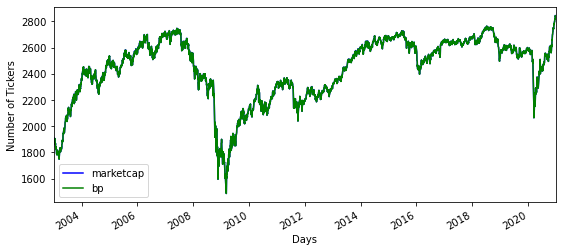

In [12]:
pipe_df.groupby(level=0)[['marketcap', 'bp']].count().plot(figsize=(9, 4), color=['blue','green'])
plt.xlabel('Days')
plt.ylabel('Number of Tickers')
plt.margins(x=0)
plt.show()

In [13]:
pipe_df.dropna(inplace=True)

### 2.3 Retrieving Adjusted Prices for Selected Stocks

With the fundamentals selected, the adjusted close price data is retrieved for the specified stocks and time horizon.

In [14]:
pipe_sids = pipe_df.index.get_level_values(1).unique()
prices_df = sep_df.set_index(['date', 'sid'])['closeadj'].unstack()
prices_df = prices_df[pipe_sids]

### 2.4 Adding Forward Returns and Deciles

This step is based on the Alphalens module for post-processing performance analysis of the Zipline pipeline data frame. Specifically, it computes cross-sectional deciles for two variables (bp and marketcap) and calculates 
forward returns for two periods: one day and one month (21 business days).

In [15]:
import alphalens as al

In [16]:
%%time
data_mi = al.utils.get_clean_factor_and_forward_returns(factor=pipe_df['bp'], 
                                                         prices=prices_df, 
                                                         quantiles=10,
                                                         periods=(1, 21))
data_mi.rename(columns={'factor': 'bp', 'factor_quantile': 'bp_decile'}, inplace=True)
data_mi.drop(['1D'], axis=1, inplace=True)

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
CPU times: user 2min 44s, sys: 12.3 s, total: 2min 56s
Wall time: 2min 56s


In [17]:
%%time
cap_data = al.utils.get_clean_factor_and_forward_returns(factor=pipe_df['marketcap'], 
                                                         prices=prices_df, 
                                                         quantiles=10,
                                                         periods=(1, 21))
cap_data.rename(columns={'factor': 'cap', 'factor_quantile': 'cap_decile'}, inplace=True)
cap_data.drop(['1D', '21D'], axis=1, inplace=True)

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
CPU times: user 1min 25s, sys: 9.55 s, total: 1min 35s
Wall time: 1min 35s


Merging two data frames

In [18]:
%%time

data_mi = pd.merge(data_mi, cap_data, left_index=True, right_index=True)
data_df = data_mi.reset_index()

CPU times: user 1min 7s, sys: 7.59 s, total: 1min 14s
Wall time: 1min 17s


<a id='section3'></a>
## 3. Building the Big HML Value and Growth Portfolios

According to the Fama-French paper (1993), the HML factor is built from the intersection of 2x3 portfolios sorted on size and book-to-market characteristics. Specifically, the two (big and small) size-related portfolios are determined by the median NYSE size. The three book-to-market portfolios are based on the breakpoints for the bottom 30% (low), middle 40% (medium) and top 30% (high) of ranked values for NYSE stocks. The corresponding portfolios are formed at the end of the year and rebalanced annually in June. 

This notebook follows the above guidance with the exception that portfolio breakpoints are determined from all stocks traded across the different exchanges. 

In [19]:
data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month

### 3.1 Selecting End-Of-Year Fundamentals Deciles

Following the HML annual rebalancing procedure, the first data frame with the marketcap and book-to-market deciles is built from the daily data by selecting the last entry of the year.

In [20]:
%%time
features_eoy = data_df.set_index(['asset', 'year']).groupby(['asset', 'year']).last().reset_index()

CPU times: user 1.11 s, sys: 856 ms, total: 1.97 s
Wall time: 2.04 s


### 3.2 Selecting Monthly Returns

The second data frame with the monthly returns is obtained by downsampling the daily data and winsorizing.


In [21]:
days = data_df.date.unique()
d21s = days[::21][:-1]
d21s = [pd.Timestamp(x) for x in d21s]
data_d21 = data_df[data_df.date.isin(d21s)]

In [22]:
from scipy.stats.mstats import winsorize

x = winsorize(data_d21['21D'].values, limits=[0.01, 0.01])
data_d21 = data_d21[(data_d21['21D'] > min(x)) & (data_d21['21D'] < max(x))]

### 3.3 Merging Monthly Returns with End-Of-Year Fundamental Features

For implementing the annual June rebalancing, both data frames are merged on the new *ffdate* shifted from the conventional year by six months.

In [23]:
%%time
from pandas.tseries.offsets import MonthEnd

data_d21['ffdate'] = data_d21['date'] + MonthEnd(-6) 
data_d21['ffyear'] = data_d21['ffdate'].dt.year

features_eoy['ffyear'] = features_eoy['date'].dt.year + 1

combo_d21 = pd.merge(data_d21[['date', 'asset', 'ffyear', '21D', 'cap']], 
                     features_eoy[['asset', 'ffyear', 'bp_decile', 'cap_decile']],
                     how='left', on=['asset','ffyear'])

combo_d21.dropna(inplace=True)

CPU times: user 119 ms, sys: 37.5 ms, total: 156 ms
Wall time: 157 ms


### 3.4 Constructing the Big HML Value and Growth  Portfolios

Following the incremental methodology, the example focuses on the top 50% of stocks based on market cap. Then, the corresponding value-weighted value and growth portfolios of the Big HML factor are built from the three top and low book-to-market deciles, respectively. 

In [24]:
combo_d21_mi = combo_d21.set_index(['date', 'asset'])

uv_df = pd.DataFrame()

bv_query = 'cap_decile > 5 and bp_decile > 7'
uv_df['BIG Value'] = combo_d21_mi.query(bv_query).groupby('date').apply(lambda x: uv.get_vw_rtn(x))

bg_query = 'cap_decile > 5 and bp_decile < 4'
uv_df['BIG Growth'] = combo_d21_mi.query(bg_query).groupby('date').apply(lambda x: uv.get_vw_rtn(x))

<a id='section4'></a>
## 4. Benchmarking Portfolios with French Data Library

As demonstrated by the previous sections, building the HML portfolios involves several datasets and post-processing transformations. Therefore, prior to the decomposition analysis, the corresponding results need to be tested with the conventional benchmark portfolios maintained and available on the [French Data Library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). 

### 4.1 Loading the HML Portfolios from French Data Library

In Python, the datasets from the French Data Library can be imported with the pandas-datareader module. The HML factor of the three-factor model (1993) and related 2x3 portfolios are located in the 'F-F_Research_Data_Factors' and '6_Portfolios_2x3' datasets, respectively.

In [25]:
import pandas_datareader.data as web

ff_factors_dataset = 'F-F_Research_Data_Factors'
factors_df = web.DataReader(ff_factors_dataset, 'famafrench', start=start_date, end=end_date)[0]

ff_portf_dataset = '6_Portfolios_2x3'
portfolios_df = web.DataReader(ff_portf_dataset, 'famafrench', start=start_date, end=end_date)[0]

ff_df = factors_df.join(portfolios_df)
ff_df['Mkt'] = ff_df['Mkt-RF'] + ff_df['RF']

In [26]:
ff_df.head(2)

,Mkt-RF,SMB,HML,RF,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM,Mkt
Date,,,,,,,,,,,
2002-12,-5.76,0.11,2.13,0.11,-8.6410,-4.6250,-3.5705,-6.1733,-3.9949,-6.9854,-5.65
2003-01,-2.57,1.30,-0.73,0.10,-2.4753,-2.5878,-1.2317,-2.8330,-1.8158,-5.5412,-2.47


### 4.2 Benchmarking Cumulative Returns

The figures below demonstrates the comparison of cumulative returns between portfolios produced by this notebook (BIG Growth and BIG Value) and the conventional benchmark from the French Data Library (BIG LoBM and BIG HiBM). 

In [27]:
dfs = [ff_df['Mkt']*0.01, 
       ff_df['BIG LoBM']*0.01, uv_df['BIG Growth'], 
       ff_df['BIG HiBM']*0.01, uv_df['BIG Value']]

colors = ['y', 'g', 'lime', 'b', 'c']
labels = ['Mkt', 'BIG LoBM (Benchmark)', 'BIG Growth', 'BIG HiBM (Benchmark)', 'BIG Value']

Text(0, 0.5, 'Cumulative Return')

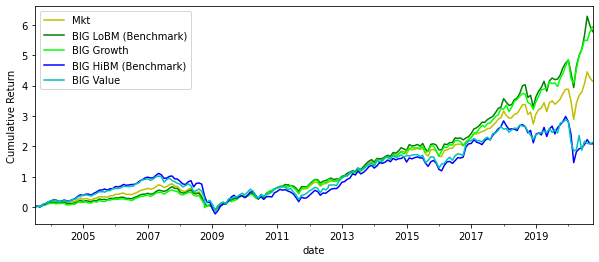

In [28]:
t1 = uv_df.index[0]; t2 = uv_df.index[-1]

fig = plt.figure(figsize=(10, 4))
for i in range(0, len(dfs)):
    ((1 + (dfs[i].loc[t1: t2])).cumprod()-1).plot(color=colors[i], label=labels[i])  
plt.legend(loc='best')
plt.ylabel('Cumulative Return')

The results indeed confirm the successful replication of the Big HML portfolios with the Sharadar data and bless the study with continuing to the stock-level decomposition analysis based on fundamental characteristics. 

<a id='section5'></a>
## 5. Loading and Post-Processing Sharadar Fundamentals

Having established the premise for replicating the value and growth portfolios, the notebook transitions to a stock-level decomposition analysis for explaining the difference in their performance demonstrated in the previous figure. Considering the growth and value assets as winners and losers, the following decomposition step explicitly connects this analysis with the related topics, such as quality and profitability of assets. After selecting the top referenced characterics (e.g, return on equity, asset growth, etc), the feature importance analysis conducted within the gradient boosting tree identified GPOA (gross profit on assets) as the primary fundamental characteristic.

### 5.1 Reading the SF1 file and selecting quarterly data

The Sharadar data bundle includes the SF1 dataset with a long list of fundamental characteristics extracted from 10-K and 10-Q reports. Based on the results of the feature importance analysis, this notebook retrieves gross profit (gp) as the primary profitability characteristic. In addition, assets, liability and equity are loaded for identifying assets with a mismatch between equity and assets-liabilities. 

In [29]:
%%time

sf1_file = bundle_dir + "SHARADAR_SF1.csv"
sf1_tags = ['dimension', 'assets', 'liabilities', 'equity',  'gp']
sf1_df = uv.read_data_file(sf1_file, tickers_df, date_tags=['reportperiod'], data_tags=sf1_tags)

# selecting quartely data
sf1_df = sf1_df.query('dimension == "ARQ"')

# selecting pipe sids
sf1_df = sf1_df[sf1_df.sid.isin(pipe_sids)]

# selecting time interval
sf1_df = sf1_df[sf1_df.reportperiod >= start_date]
sf1_df = sf1_df[sf1_df.reportperiod <= end_date]

print('selected stocks:', len(sf1_df.sid.unique()))

selected stocks: 6567
CPU times: user 9.74 s, sys: 575 ms, total: 10.3 s
Wall time: 10.7 s


### 5.2 Selecting End of Year Data

Identifying and then selecting the entries representing the end of year data.

In [30]:
%%time

sf1_df['year'] = sf1_df['reportperiod'].dt.year
sf1_df['month'] = sf1_df['reportperiod'].dt.month

sf1_eoy = sf1_df.set_index(['sid', 'year']).groupby(['sid', 'year']).last().reset_index()

sf1_eoy = sf1_eoy.query('month > 9')

CPU times: user 87 ms, sys: 12.6 ms, total: 99.7 ms
Wall time: 98.7 ms


### 5.3 Adding New Attributes

Adding new ratios of interest: equity ratio and and gross profits on assets (gpoa). 

In [31]:
sf1_eoy['total_equity'] = sf1_eoy['assets'] - sf1_eoy['liabilities']
sf1_eoy['equity_ratio'] = sf1_eoy['equity']/sf1_eoy['total_equity']

sf1_eoy['gpoa'] = sf1_eoy['gp']/sf1_eoy['assets']
sf1_eoy.dropna(inplace=True)

### 5.4 Adding Deciles

Computing the stock ranks based on the gpoa ratio for the subsequent decomposition analysis. 

In [32]:
sf1_eoy = sf1_eoy.set_index(['year', 'sid'])
sf1_eoy['gpoa_decile'] = sf1_eoy.groupby('year').apply(lambda x: uv.calc_var_decile(x, 'gpoa'))
sf1_eoy = sf1_eoy.reset_index()

<a id='section6'></a>
## 6. Decomposing Big HML into High and Low GPOA

This step explores and visualizes the structure of the Big HML growth and value portfolios via the GPOA deciles.

### 6.1 Updating the End-Of-Year Features with GPOA Deciles

For decomposing the HML portfolios, their end-of-year features need to be merged with the gpoa deciles.

In [33]:
%%time

sf1_eoy.rename(columns = {'sid': 'asset'}, inplace=True)
sf1_eoy['ffyear'] = sf1_eoy['year'] + 1

features_eoy = pd.merge(features_eoy[['asset', 'ffyear', 'bp_decile', 'cap_decile']],
                       sf1_eoy[['asset', 'ffyear', 'total_equity', 'equity_ratio', 'gpoa_decile']], 
                       how='left', on=['asset','ffyear'])

CPU times: user 16.8 ms, sys: 3.69 ms, total: 20.5 ms
Wall time: 18.8 ms


### 6.2 Area Plots

Then, the GPOA-based decomposition can be transparently visualized via the corresponding area plots demonstrating temporal dynamics of the top 50% and bottom 50% GPOA-ranked assets within the big value and growth portfolios.

In [34]:
def get_asset_count(x, query):
    return x.query(query)['asset'].count()

In [35]:
features_eoy = features_eoy.set_index(['ffyear'])

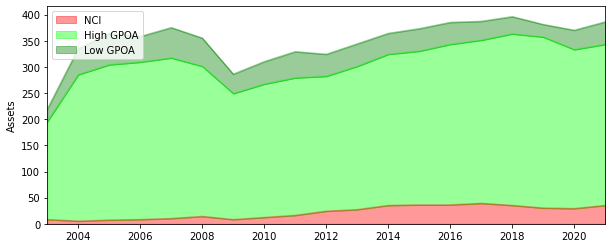

In [36]:
# Big Growth
bg_area_plot = pd.DataFrame()
bg_queries = uv.get_gpoa_queries('cap_decile > 5 and bp_decile < 4')

for key in bg_queries:
    bg_area_plot[key] = features_eoy.groupby('ffyear').apply(lambda x: get_asset_count(x, bg_queries[key]))

bg_colors = {'NCI': 'r', 'High GPOA': 'lime', 'Low GPOA': 'g'}
ax = bg_area_plot.plot.area(figsize=(10, 4), color=bg_colors, alpha=0.4)
ax.set_ylabel('Assets')
ax.set_xlabel(None)
ax.legend(loc='upper left')
ax.margins(x=0)

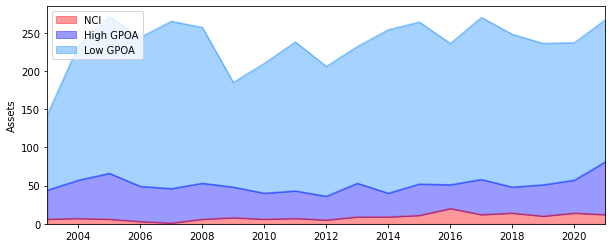

In [37]:
# Big Value
bv_area_plot = pd.DataFrame()
bv_queries = uv.get_gpoa_queries('cap_decile > 5 and bp_decile > 7')

for key in bv_queries:
    bv_area_plot[key] = features_eoy.groupby('ffyear').apply(lambda x: get_asset_count(x, bv_queries[key]))

bv_colors = {'NCI': 'r', 'High GPOA': 'b', 'Low GPOA': 'dodgerblue'}
ax = bv_area_plot.plot.area(figsize=(10, 4), color=bv_colors, alpha=0.4)
ax.set_ylabel('Assets')
ax.set_xlabel(None)
ax.legend(loc='upper left')
ax.margins(x=0)

In [38]:
features_eoy = features_eoy.reset_index()

As shown by the above area plots, big growth (winners) are mostly formed from stocks with a high GPOA rank while the high book-to-market value portfolio is mostly composed of low GPOA stocks. Importanly, the portfolio composition remains relatively stable through the entire interval.

<a id='section7'></a>
## 7. Comparing Value and Growth Performance with GPOA-based Partitions

The final step complements the above decomposition analysis through the comparison of the cumulative returns between the HML portfolios and the GPOA-based partitions.

### 7.1 Building GPOA-related portfolios

The construction of the GPOA-based partitions follows the same procedure used for building the HML portfolios by extending the corresponding data frame with new end-of-year features.

In [39]:
combo_d21 = pd.merge(combo_d21, 
                     features_eoy[['asset', 'ffyear', 'gpoa_decile', 'equity_ratio', 'total_equity']],
                     how='left', on=['asset','ffyear'])

and applying composite queries extended with GPOA-related conditions.

In [40]:
combo_d21_mi = combo_d21.set_index(['date', 'asset'])
common_query = 'equity_ratio > 0.8 and total_equity > 0 and cap_decile > 5'

growth_hg = '{} and bp_decile < 4 and gpoa_decile > 5'.format(common_query)
uv_df['BIG Growth Hi GPOA'] = combo_d21_mi.query(growth_hg).groupby('date').apply(lambda x: uv.get_vw_rtn(x))

value_lg = '{} and bp_decile > 7 and gpoa_decile < 6'.format(common_query)
uv_df['BIG Value Lo GPOA'] = combo_d21_mi.query(value_lg).groupby('date').apply(lambda x: uv.get_vw_rtn(x))

### 7.2 Comparing Cumulative Returns

The figure below provides the comparison of cumulative returns between the HML portfolios and their GPOA partitions.

In [41]:
dfs = [ff_df['Mkt']*0.01, 
       uv_df['BIG Growth'], uv_df['BIG Growth Hi GPOA'],
       uv_df['BIG Value'], uv_df['BIG Value Lo GPOA']]
colors = ['y', 'g', 'lime', 'b', 'c']
labels = ['Mkt', 'BIG Growth', 'BIG Growth Hi GPOA', 'BIG Value', 'BIG Value Lo GPOA']

Text(0, 0.5, 'Cumulative Return')

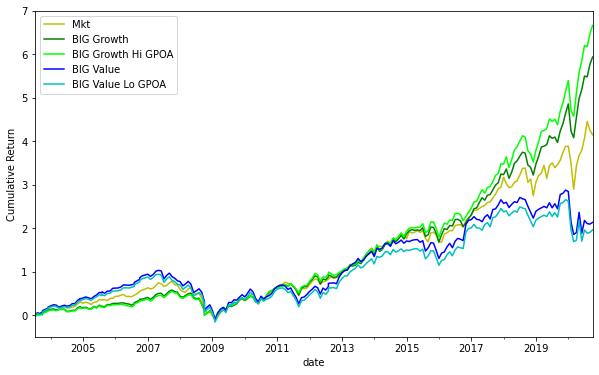

In [42]:
t1 = uv_df.index[0]; t2 = uv_df.index[-1]

fig = plt.figure(figsize=(10, 6))
for i in range(0, len(dfs)):
    ((1 + (dfs[i].loc[t1: t2:1])).cumprod()-1).plot(color=colors[i], label=labels[i])  
plt.legend(loc='best')
plt.ylabel('Cumulative Return')

The plots confirm the description of the Big HML portfolio structure based on the GPOA characteristic. Futhermore, the discrepancy between these portfolios and their GPOA-based partitions identifies the level of contibution from other assets. As a result, this gap provides guidance for finding additional characteristics to explain, for example, winners (growth) with low GPOA values. Then, the ultimate goal of the study is to describe the perforamnce of the HML portfolios directly with fundamental and macroeconomics characteristics for establishing the empirical and theoretical pricing models of assets.